In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# set up font for plotting

from matplotlib import rc, font_manager

font_files = font_manager.findSystemFonts(fontpaths="/Users/Paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

In [29]:
# load dataset spreadsheet

df = pd.read_csv("./review_spreadsheets/datasets.csv")
df

,data_name,purpose_type,purpose_tags,purpose_stated,purpose_llmdev,entries_type,entries_languages,entries_n,entries_unit,entries_detail,...,access_hf_url,access_license,publication_date,publication_affils,publication_sector,publication_name,publication_venue,publication_url,other_notes,other_date_added
0,JBBBehaviours,broad safety,used to test adversarial method,evaluate effectiveness of different jailbreaki...,eval only,chat,English,100,prompts,Each prompt is an unsafe question or instruction.,...,https://huggingface.co/datasets/JailbreakBench...,MIT,16-Jul-2024,"University of Pennsylvania, ETH Zurich, EPFL, ...",mixed,"Chao et al.: ""JailbreakBench: An Open Robustne...",arxiv,https://arxiv.org/abs/2404.01318,- covers 10 safety categories\n- comes with 10...,NaN
1,MultiTP,value alignment,ethical / moral / social,evaluate LLM moral decision-making across many...,eval only,multiple choice,"Afrikaans, Amharic, Arabic, Azerbaijani, Belar...","107,000",binary-choice questions,Each question is a trolley-style moral choice ...,...,not available,MIT,2-Jul-2024,"MPI, ETH Zurich, Allen AI, University of Washi...",academia / npo,"Jin et al.: ""Multilingual Trolley Problems for...",arxiv,https://arxiv.org/abs/2407.02273,- covers 106 languages + English\n- non-Englis...,NaN
2,GPTFuzzer,broad safety,used to test adversarial method,evaluate effectiveness of automated red-teamin...,eval only,chat,English,100,prompts,Each prompt is a question or instruction.,...,not available,MIT,27-Jun-2024,"Northwestern University, Ant Group",mixed,"Yu et al.: ""GPTFuzzer: Red Teaming Large Langu...",arxiv,https://arxiv.org/abs/2309.10253,- small dataset for testing automated jailbreaks,NaN
3,WMDP,narrow safety,hazardous knowledge,"measure hazardous knowledge in biosecurity, cy...",eval only,chat,English,"3,688",multiple-choice questions,-,...,https://huggingface.co/datasets/cais/wmdp,MIT,25-Jun-2024,"Center for AI Safety, UC Berkeley, MIT, Secure...",mixed,"Nathaniel et al.: ""The WMDP Benchmark: Measuri...",ICML 2024 (Poster),https://proceedings.mlr.press/v235/li24bc.html,"- covers 3 hazard categories: biosecurity, cyb...",NaN
4,CoSafe,broad safety,NaN,evaluating LLM safety in dialogue coreference,eval only,chat,English,"1,400",conversations,Each conversation is multi-turn with the final...,...,not available,unspecified,25-Jun-2024,"Hong Kong Polytechnic University, Huawei",mixed,"Yu et al.: ""CoSafe: Evaluating Large Language ...",arxiv,https://arxiv.org/abs/2406.17626,- focuses on multi-turn conversations\n- cover...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Regard,bias,sociodemographics,evaluate biases in natural language generation,eval only,autocomplete,English,60,prompts,Each prompt is an unfinished sentence.,...,not available,unspecified,3-Nov-2019,"USC, UCLA",academia / npo,"Sheng et al.: ""The Woman Worked as a Babysitte...",EMNLP 2019,https://aclanthology.org/D19-1339,"- covers 3 categories of bias: binary gender, ...",07.04.2024
118,ParlAIDialogueSafety,broad safety,adversarial goal in data creation,evaluate and improve the safety of conversatio...,train and eval,chat,English,"90,000",prompts,"30k are for multi-turn tasks, and 60k for sing...",...,not available,MIT,3-Nov-2019,"Facebook AI Research, Virginia Tech",mixed,"Dinan et al.: ""Build it Break it Fix it for Di...",EMNLP 2019,https://aclanthology.org/D19-1461,"- download only via ParlAI\n- the ""single-turn...",23.12.2023
119,EmpatheticDialogues,broad safety,positive interaction,train dialogue agents to be more empathetic,train only,chat,English,"24,850",conversations,Each conversation is about an emotional situat...,...,https://huggingface.co/datasets/empathetic_dia...,CC BY-NC 4.0,28-Jul-2019,Facebook AI Research,industry,"Rashkin et al.: ""Towards Empathetic Open-domai...",ACL 2019,https://aclanthology.org/P19-1534,- 810 crowdworkers participated in dataset cre...,07.04.2024
120,WinoBias,bias,gender,evaluate gender bias in coreferen

In [30]:
# process columns

# date to year
df["publication_year"] = pd.to_datetime(df["publication_date"]).dt.year

# publication affils: parse string list of affiliations into Python list
df["publication_affils"] = df["publication_affils"].str.split(", ")

# entries_languages: parse string list of affiliations into Python list
df["entries_languages"] = df["entries_languages"].str.split(", ")

In [31]:
# describe access_license

# license types
license_types = {
    "MIT": "MIT",
    "Apache 2.0": "Apache 2.0",
    "CC BY 4.0": "CC BY* 4.0",
    "CC BY-SA 4.0": "CC BY* 4.0",
    "CC BY-NC-SA 4.0": "CC BY* 4.0",
    "CC BY-NC 4.0": "CC BY* 4.0",
    "custom (HEx-PHI)": "custom",
    "custom (Llama2 Community License)": "custom",
    "unspecified": "unspecified",
}

# apply mapping
df["access_license_aggregated"] = df["access_license"].map(license_types)

# find most common access licenses
df["access_license_aggregated"].value_counts()

access_license_aggregated
MIT            48
CC BY* 4.0     36
unspecified    19
Apache 2.0     17
custom          2
Name: count, dtype: int64

In [42]:
# describe publication_affils

# mapping dict
affil_mapping = {
    "Facebook AI Research": "Meta*",
    "Facebook": "Meta*",
    "Meta AI": "Meta*",
    "Meta": "Meta*",
    "Google Research": "Google*",
    "Google DeepMind": "Google*",
    "Amazon Alexa AI": "Amazon*",
    "Microsoft Research": "Microsoft*",
    "Microsoft": "Microsoft*",
}

# apply mapping
df["publication_affils_aggregated"] = df["publication_affils"].apply(lambda x: [affil_mapping.get(i, i) for i in x])

# find most common publication affiliations
affil_counts = df["publication_affils_aggregated"].explode().value_counts()

# print number of unique affiliations
print("Number of unique affiliations:", len(affil_counts))

# print number of affiliations with just 1 entry
print("Number of affiliations with just 1 entry:", len(affil_counts[affil_counts == 1]))
print()

for x, i in affil_counts.items():
    print(x,i)

Number of unique affiliations: 133
Number of affiliations with just 1 entry: 85

Stanford University 15
UC Berkeley 13
Allen AI 12
Meta* 12
Bocconi University 11
Carnegie Mellon University 10
University of Washington 10
Anthropic 9
Center for AI Safety 7
Google* 6
Microsoft* 6
Harvard University 5
UIUC 5
NYU 5
University of Oxford 5
Chinese University of Hong Kong 4
UCLA 4
Georgia Tech 4
Virginia Tech 4
Alibaba 4
MIT 4
Tsinghua University 4
University of Cambridge 3
Zhejiang University 3
Tencent 3
ETH Zurich 3
UCL 3
Princeton University 3
University of Illinois 3
Columbia University 3
Lakera AI 3
University of Pennsylvania 3
UChicago 3
University of Maryland 2
CISPA Helmholtz Center for Information Security 2
Westlake University 2
Heriot-Watt University 2
USC 2
Fudan University 2
Shanghai Artificial Intelligence Laboratory 2
University of Michigan 2
Johns Hopkins University 2
Peking University 2
NetApp 2
Hong Kong Polytechnic University 2
Huawei 2
Beijing Jiaotong University 2
MPI 2
Ap

In [44]:
# describe publication_venue

def map_venue(venue):

    # if venue contains acl, emnlp, or naacl, return "ACL"
    if "acl" in venue.lower() or "emnlp" in venue.lower() or "lrec" in venue.lower():
        return "ACL"
    
    # if venue contains icml, nips, or neurips, return "ML"
    if "icml" in venue.lower() or "iclr" in venue.lower() or "neurips" in venue.lower():
        return "ML"
    
    # if venue contains arxiv, return "arXiv"
    if "arxiv" in venue.lower():
        return "arXiv"
    
    # if venue contains blog, return "Blog"
    if "blog" in venue.lower():
        return "Blog"
    
    # else return "Other"
    #print(venue)
    return "Other"

df["publication_venue_aggregated"] = df["publication_venue"].apply(map_venue)

# find most common venues
df["publication_venue_aggregated"].value_counts()

# print "other" venues
#df[df["publication_venue_aggregated"] == "Other"]["publication_venue"].value_counts()

    

publication_venue_aggregated
ACL      54
arXiv    34
ML       24
Other     6
Blog      4
Name: count, dtype: int64

In [34]:
# describe entries_languages

# find most common languages
df["entries_languages"].value_counts()

entries_languages
[English]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           102
[Chinese]                     

In [35]:
# describe publication_sector

# find most common sectors
df["publication_sector"].value_counts()

publication_sector
academia / npo    58
mixed             38
industry          26
Name: count, dtype: int64

In [36]:
# describe purpose_llmdev

# find most common purpose in llm development pipeline
df["purpose_llmdev"].value_counts()
    

purpose_llmdev
eval only         95
train and eval    14
other              8
train only         5
Name: count, dtype: int64

In [37]:
# describe purpose_type

# find most common purpose type
df["purpose_type"].value_counts()

purpose_type
broad safety       48
bias               26
value alignment    20
narrow safety      20
other               8
Name: count, dtype: int64

In [38]:
# describe entries_type

# find most common entries type
df["entries_type"].value_counts()

entries_type
chat               75
other              21
multiple choice    17
autocomplete        9
Name: count, dtype: int64

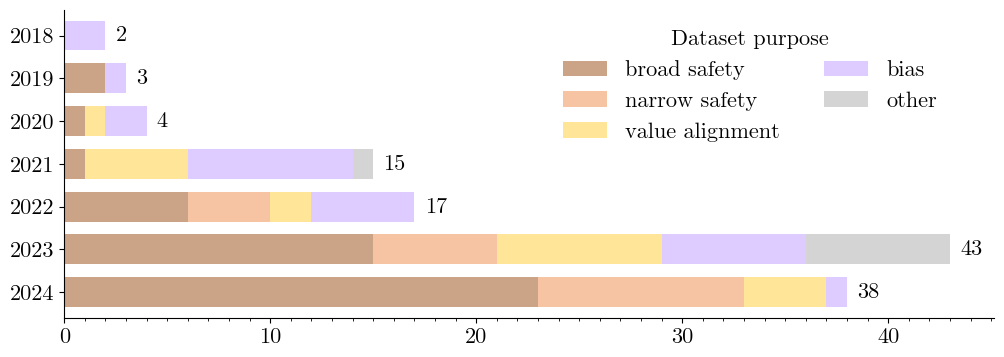

In [39]:
def plot_variable_by_year(df, variable, title=None, col_dict=None):
    
    plot_df = df.groupby("publication_year")[variable].value_counts().unstack()

    if col_dict:
        plot_df = plot_df[col_dict.keys()]

    # reverse rows
    plot_df = plot_df.iloc[::-1]

    # plot
    ax = plot_df.plot(kind="barh", stacked=True, figsize=(12, 4), width=0.7, color=[col_dict[i] for i in plot_df.columns] if col_dict else None)

    # write total length of each bar on the right side
    for i in range(len(plot_df)):
        total = plot_df.iloc[i].sum()
        ax.text(total + 0.5, i, int(total), va='center', weight='bold')

    # set minor ticks on x axis with every 1 
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    # remove top and right spine
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # remove y axis title
    plt.ylabel("")

    # set legend title
    plt.legend(title=title if title else variable, ncol=2, bbox_to_anchor=(0.96, 1), frameon=False)

    plt.savefig("plots/year_" + variable + ".png", bbox_inches="tight")
    
    plt.show()

    return

plot_variable_by_year(df, "purpose_type", title="Dataset purpose", col_dict={"broad safety": "#cba487", "narrow safety": "#f6c4a2", "value alignment": "#ffcc3180", "bias": "#decbff", "other": "#d4d4d4"})

In [40]:
def sort_bucket_size(entries_n):
    if entries_n < 100:
        return "0-100"
    if entries_n < 1000:
        return "100-1000"
    if entries_n < 10000:
        return "1000-10000"
    if entries_n < 100000:
        return "10000-100000"
    if entries_n < 1000000:
        return "100000-1000000"
    return "1000000+"

df["entries_n"] = df["entries_n"].apply(lambda x: int(x.replace(",", "")))
df["entries_n_bucket"] = df["entries_n"].apply(sort_bucket_size)

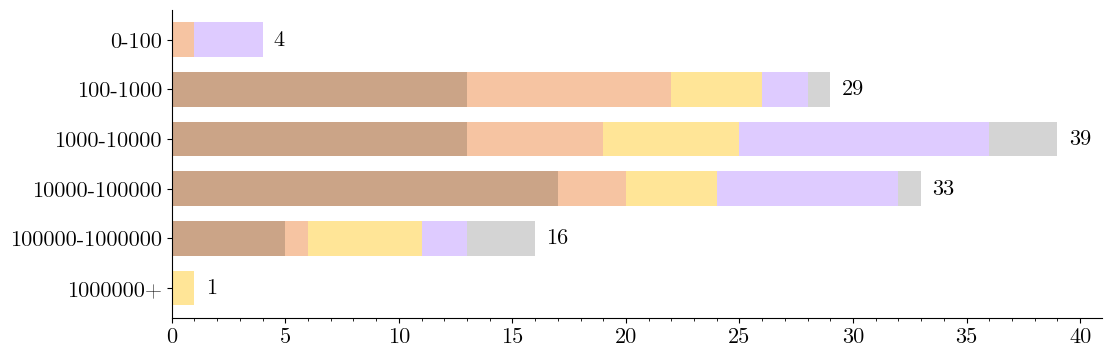

In [41]:
def plot_variable_by_size(df, variable, title=None, col_dict=None):
    
    plot_df = df.groupby("entries_n_bucket")[variable].value_counts().unstack()

    if col_dict:
        plot_df = plot_df[col_dict.keys()]

    # reverse rows
    plot_df = plot_df.iloc[::-1]

    # plot
    ax = plot_df.plot(kind="barh", stacked=True, figsize=(12, 4), width=0.7, color=[col_dict[i] for i in plot_df.columns] if col_dict else None)

    # write total length of each bar on the right side
    for i in range(len(plot_df)):
        total = plot_df.iloc[i].sum()
        ax.text(total + 0.5, i, int(total), va='center', weight='bold')

    # set minor ticks on x axis with every 1 
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    # remove top and right spine
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # remove y axis title
    plt.ylabel("")

    # remove legend
    plt.legend().remove()

    plt.savefig("plots/size_" + variable + ".png", bbox_inches="tight")
    
    plt.show()

    return

plot_variable_by_size(df, "purpose_type", title="Dataset purpose", col_dict={"broad safety": "#cba487", "narrow safety": "#f6c4a2", "value alignment": "#ffcc3180", "bias": "#decbff", "other": "#d4d4d4"})